### Loading Data and libraries

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# paths
mrl_root = "Data/MRL/data"


# Show where we are starting
print("Before:", os.getcwd())

print("Before:", os.getcwd())

if os.path.basename(os.getcwd()) != "Deep-Learning-Drowsiness-Prediction":
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")

print("Now in:", os.getcwd())
print("Listing:", os.listdir())

print("Now in:", os.getcwd())
print("Listing:", os.listdir())  # you should see Data, README.md, etc.

IMG_SIZE = (64, 64)
BATCH_SIZE = 64

train_dir = os.path.join(mrl_root, "train")
val_dir   = os.path.join(mrl_root, "val")
test_dir  = os.path.join(mrl_root, "test")

2025-12-04 23:55:46.109142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764892547.032849   48578 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764892547.301894   48578 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764892549.734372   48578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764892549.734422   48578 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764892549.734425   48578 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsiness/code
Before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsiness/code
Now in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsiness/code/Deep-Learning-Drowsiness-Prediction
Listing: ['.git', '.gitignore', 'Data', 'Data Gathering', 'Modeling', 'Models', 'README.md']
Now in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsiness/code/Deep-Learning-Drowsiness-Prediction
Listing: ['.git', '.gitignore', 'Data', 'Data Gathering', 'Modeling', 'Models', 'README.md']


### Preprocessing and augmentation

In [2]:
base_train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

base_val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

base_test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Class names:", base_train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
])

def preprocess(image, label, training=False):
    image = tf.cast(image, tf.float32) / 255.0
    if training:
        image = data_augmentation(image, training=True)
    return image, label

def prepare_dataset(ds, training=False):
    ds = ds.map(
        lambda x, y: preprocess(x, y, training=training),
        num_parallel_calls=AUTOTUNE,
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(base_train_ds, training=True)
val_ds   = prepare_dataset(base_val_ds,   training=False)
test_ds  = prepare_dataset(base_test_ds,  training=False)

Found 50937 files belonging to 2 classes.


I0000 00:00:1764892572.828781   48578 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 16980 files belonging to 2 classes.
Found 16981 files belonging to 2 classes.
Class names: ['awake', 'sleepy']


### Model 1- Baseline CNN (per-frame awake vs sleepy)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def build_baseline_cnn(input_shape=(64, 64, 1)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn_mrl")
    return model

model_cnn = build_baseline_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model_cnn.summary()

Model: "baseline_cnn_mrl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,505 (4.35 MB)

 Trainable params: 1,141,505 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/15


2025-12-04 23:56:31.311401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 31 of 1000
2025-12-04 23:56:51.264072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 94 of 1000
2025-12-04 23:57:01.365499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 129 of 1000
2025-12-04 23:57:21.373484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 202 of 1000
2025-12-04 23:57:41.180340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 276 of 1000
2025-12-04 23:57:51.361047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a wh

796/796 - 301s - 378ms/step - accuracy: 0.9039 - loss: 0.2410 - val_accuracy: 0.9516 - val_loss: 0.1313
Epoch 2/15
796/796 - 4s - 5ms/step - accuracy: 0.9597 - loss: 0.1158 - val_accuracy: 0.9716 - val_loss: 0.0764
Epoch 3/15
796/796 - 4s - 5ms/step - accuracy: 0.9694 - loss: 0.0864 - val_accuracy: 0.9747 - val_loss: 0.0709
Epoch 4/15
796/796 - 4s - 5ms/step - accuracy: 0.9733 - loss: 0.0741 - val_accuracy: 0.9766 - val_loss: 0.0651
Epoch 5/15
796/796 - 4s - 5ms/step - accuracy: 0.9784 - loss: 0.0635 - val_accuracy: 0.9790 - val_loss: 0.0595
Epoch 6/15
796/796 - 4s - 5ms/step - accuracy: 0.9803 - loss: 0.0566 - val_accuracy: 0.9807 - val_loss: 0.0550
Epoch 7/15
796/796 - 4s - 5ms/step - accuracy: 0.9816 - loss: 0.0519 - val_accuracy: 0.9761 - val_loss: 0.0640
Epoch 8/15
796/796 - 4s - 5ms/step - accuracy: 0.9840 - loss: 0.0463 - val_accuracy: 0.9784 - val_loss: 0.0556
Epoch 9/15
796/796 - 4s - 5ms/step - accuracy: 0.9847 - loss: 0.0418 - val_accuracy: 0.9841 - val_loss: 0.0455
Epoch 10

In [5]:
test_loss, test_acc = model_cnn.evaluate(test_ds, verbose=2)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

2025-12-05 00:03:13.431623: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[21,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,32,32,32]{3,2,1,0} %bitcast.411, f32[64,32,3,3]{3,2,1,0} %bitcast.418, f32[64]{0} %bitcast.420), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="baseline_cnn_mrl_1/conv2d_1_2/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-05 00:03:13.449411: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

266/266 - 70s - 263ms/step - accuracy: 0.9845 - loss: 0.0441
Test accuracy: 0.9844532012939453
Test loss: 0.04406823590397835


### Save model

In [6]:
model_cnn.save("Models/baseline_cnn_mrl.keras", save_format = "keras_v3")

model_cnn.save("Models/baseline_cnn_mrl.h5",save_format="h5")


### Graphs

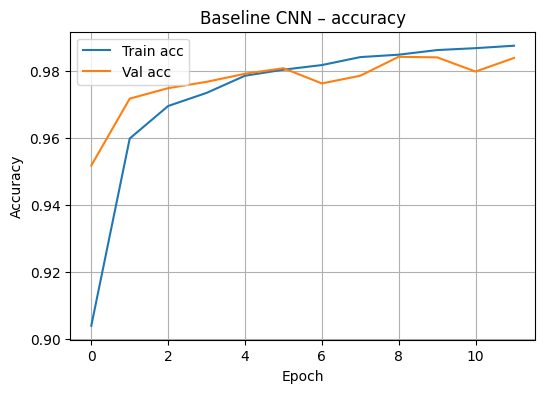

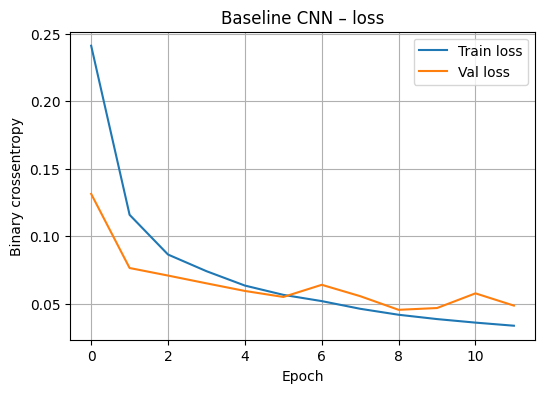

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    hist = history.history

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Baseline CNN – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.title("Baseline CNN – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(history)

### Evaluation on test set

In [8]:
import sys
!{sys.executable} -m pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 34.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1) Overall test performance
test_loss, test_acc = model_cnn.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# 2) Collect predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy().ravel())
    y_pred.extend((preds.ravel() > 0.5).astype(int))  # threshold 0.5

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

target_names = ["awake", "sleepy"]
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9858 - loss: 0.0386
Test accuracy: 0.9844532012939453
Test loss: 0.04406823590397835


2025-12-05 00:03:23.392317: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0} %bitcast.244, f32[64,32,3,3]{3,2,1,0} %bitcast.251, f32[64]{0} %bitcast.253), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="baseline_cnn_mrl_1/conv2d_1_2/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-05 00:03:23.423165: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

y_true shape: (16981,)
y_pred shape: (16981,)
              precision    recall  f1-score   support

       awake       0.98      0.99      0.98      8591
      sleepy       0.99      0.98      0.98      8390

    accuracy                           0.98     16981
   macro avg       0.98      0.98      0.98     16981
weighted avg       0.98      0.98      0.98     16981

Confusion matrix:
 [[8472  119]
 [ 145 8245]]


2025-12-05 00:03:40.542300: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-12-05 00:03:57.564458: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


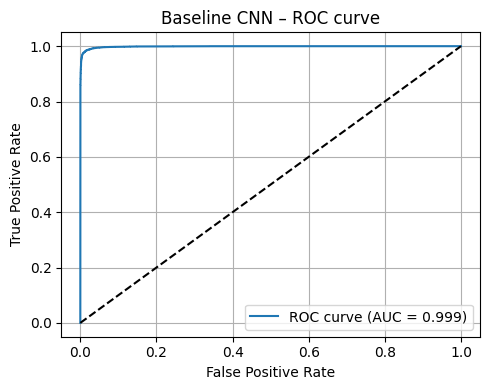

In [10]:
from sklearn.metrics import roc_curve, auc

# Get continuous probabilities instead of thresholded y_pred
y_scores = []
for images, labels in test_ds:
    preds = model_cnn.predict(images, verbose=0).ravel()
    y_scores.extend(preds)

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Baseline CNN – ROC curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Error analysis

In [11]:
import numpy as np
from pathlib import Path

# Rebuild a dataset with file paths attached so we can see which images were wrong
file_paths = []
labels_list = []
for batch, labels in base_test_ds.unbatch().as_numpy_iterator():
    # base_test_ds is built from directory, so we recreate file paths via file_names attribute
    pass

In [12]:
test_dir = Path(test_dir)

file_paths = []
true_labels = []

for cls_idx, cls_name in enumerate(sorted(os.listdir(test_dir))):
    cls_folder = test_dir / cls_name
    if not cls_folder.is_dir():
        continue
    for p in cls_folder.glob("*.png"):
        file_paths.append(str(p))
        true_labels.append(0 if cls_name == "awake" else 1)

file_paths = np.array(file_paths)
true_labels = np.array(true_labels)

In [13]:
from tensorflow import keras
from PIL import Image

def preprocess_path(path):
    img = Image.open(path).convert("L").resize(IMG_SIZE)
    arr = np.array(img, dtype="float32") / 255.0
    arr = arr[..., np.newaxis]  # (H,W,1)
    return arr

X = np.stack([preprocess_path(p) for p in file_paths])
y_true = true_labels
y_scores = model_cnn.predict(X, batch_size=64, verbose=0).ravel()
y_pred = (y_scores > 0.5).astype(int)

mis_idx = np.where(y_pred != y_true)[0]
len(mis_idx)

265

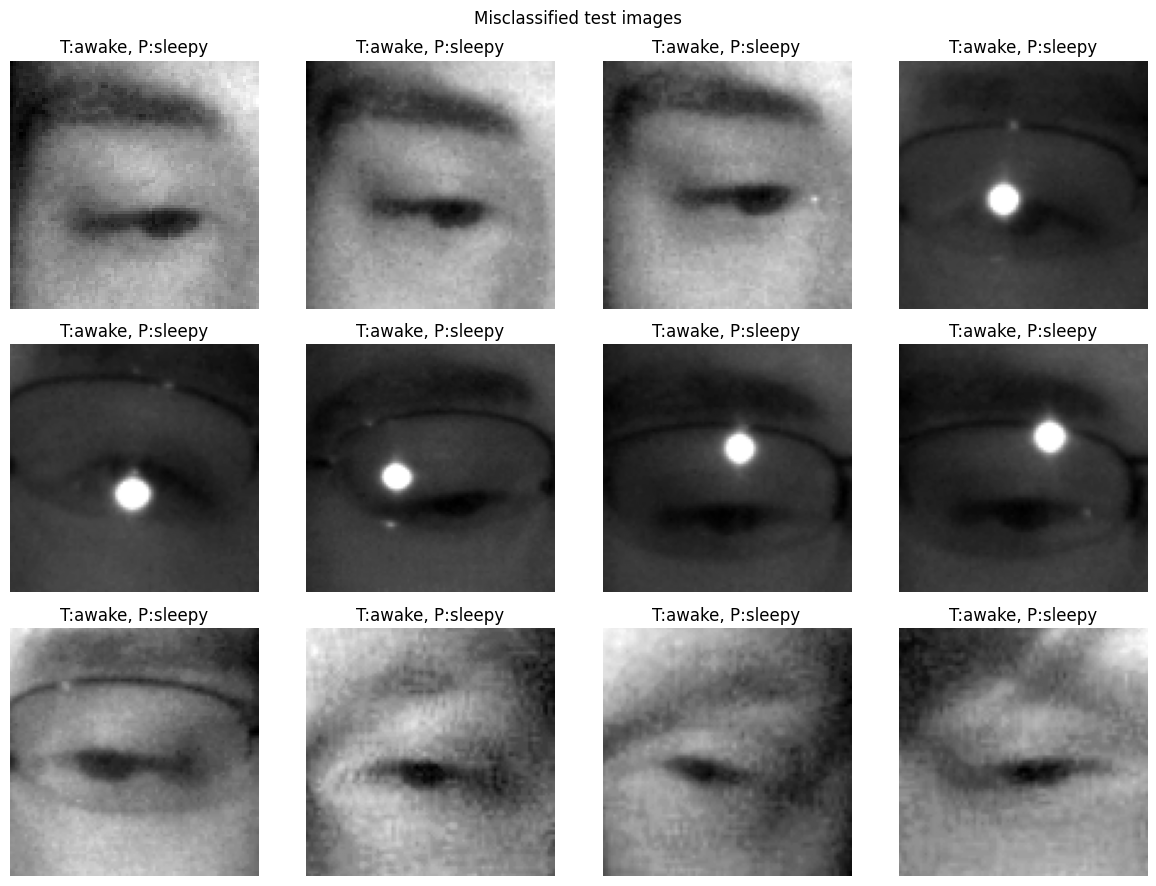

In [14]:
import matplotlib.pyplot as plt

def show_mistakes(indices, n=12):
    indices = indices[:n]
    cols = 4
    rows = int(np.ceil(len(indices) / cols))
    plt.figure(figsize=(3*cols, 3*rows))

    for i, idx in enumerate(indices):
        img = Image.open(file_paths[idx]).convert("L")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        true_lbl = "awake" if y_true[idx] == 0 else "sleepy"
        pred_lbl = "awake" if y_pred[idx] == 0 else "sleepy"
        plt.title(f"T:{true_lbl}, P:{pred_lbl}")
        plt.axis("off")

    plt.suptitle("Misclassified test images")
    plt.tight_layout()
    plt.show()

show_mistakes(mis_idx, n=12)

### New better CNN attempt: augmentation based on driver conditions

In [15]:
# =========================================================
# Stronger augmentation for driver conditions (new pipeline)
# =========================================================
from tensorflow.keras import layers

driver_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.10),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomContrast(0.20),
        layers.GaussianNoise(0.02),
    ],
    name="driver_augmentation",
)

def preprocess_driver(image, label, training: bool = False):
    # Normalize to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # Apply stronger augmentations only for training
    if training:
        image = driver_augmentation(image, training=True)
    return image, label

def prepare_dataset_driver(ds, training: bool = False):
    ds = ds.map(
        lambda x, y: preprocess_driver(x, y, training=training),
        num_parallel_calls=AUTOTUNE,
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

# New datasets for the augmented experiment
train_ds_driver = prepare_dataset_driver(base_train_ds, training=True)
val_ds_driver   = prepare_dataset_driver(base_val_ds,   training=False)
test_ds_driver  = prepare_dataset_driver(base_test_ds,  training=False)

In [16]:
# =========================================================
# New model: CNN with stronger driver augmentations
# =========================================================
def build_cnn_driver_aug(input_shape=(64, 64, 1)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="cnn_mrl_driver_aug")
    return model

model_cnn_aug = build_cnn_driver_aug(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model_cnn_aug.summary()

model_cnn_aug.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

early_stop_aug = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

Model: "cnn_mrl_driver_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,505 (4.35 MB)

 Trainable params: 1,141,505 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =========================================================
# Train augmented model
# =========================================================
history_aug = model_cnn_aug.fit(
    train_ds_driver,
    validation_data=val_ds_driver,
    epochs=15,
    callbacks=[early_stop_aug],
    verbose=2,
)

# Test performance
test_loss_aug, test_acc_aug = model_cnn_aug.evaluate(test_ds_driver, verbose=2)
print("Augmented model – test accuracy:", test_acc_aug)
print("Augmented model – test loss:", test_loss_aug)

# Save
os.makedirs("Models", exist_ok=True)
aug_model_path = "Models/cnn_mrl_driver_aug.keras"
model_cnn_aug.save(aug_model_path,save_format="keras_v3")
print("Saved augmented model to:",aug_model_path)
aug_model_path = "Models/cnn_mrl_driver_aug.h5"
model_cnn_aug.save(aug_model_path, save_format="h5")
print("Saved augmented model to:",aug_model_path)



Epoch 1/15


2025-12-05 00:10:15.785118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this may take a while): 26 of 1000
2025-12-05 00:10:25.825805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this may take a while): 55 of 1000
2025-12-05 00:10:45.758074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this may take a while): 120 of 1000
2025-12-05 00:11:05.673532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this may take a while): 182 of 1000
2025-12-05 00:11:15.830549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this may take a while): 216 of 1000
2025-12-05 00:11:35.870606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:6975: Filling up shuffle buffer (this m

796/796 - 297s - 373ms/step - accuracy: 0.9008 - loss: 0.2448 - val_accuracy: 0.9617 - val_loss: 0.1028
Epoch 2/15
796/796 - 4s - 5ms/step - accuracy: 0.9553 - loss: 0.1238 - val_accuracy: 0.9645 - val_loss: 0.0980
Epoch 3/15


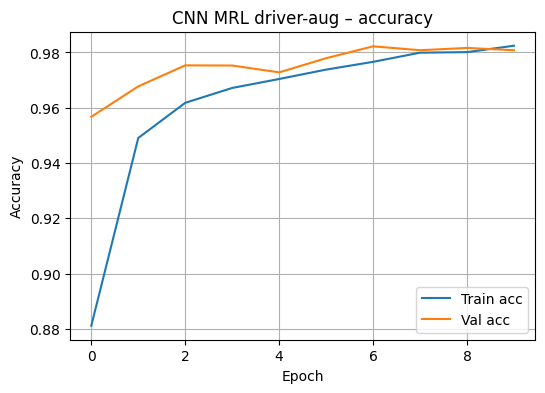

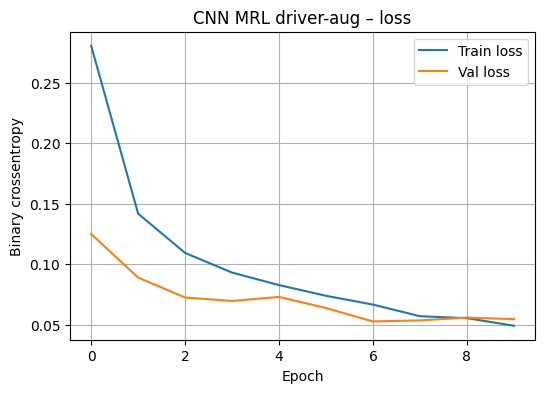

2025-12-03 04:51:14.755536: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Augmented model – classification report
              precision    recall  f1-score   support

       awake       0.98      0.98      0.98      8591
      sleepy       0.98      0.98      0.98      8390

    accuracy                           0.98     16981
   macro avg       0.98      0.98      0.98     16981
weighted avg       0.98      0.98      0.98     16981

Augmented model – confusion matrix:
 [[8428  163]
 [ 151 8239]]


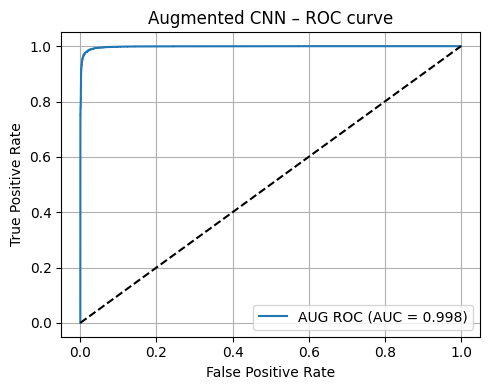

In [23]:
# =========================================================
# Training curves for augmented model
# =========================================================
def plot_training_curves_with_title(history, title_prefix="Model"):
    hist = history.history

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.title(f"{title_prefix} – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves_with_title(history_aug, title_prefix="CNN MRL driver-aug")

# =========================================================
# Classification report + confusion matrix for augmented model
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_true_aug = []
y_pred_aug = []
y_scores_aug = []

for images, labels in test_ds_driver:
    probs = model_cnn_aug.predict(images, verbose=0).ravel()
    y_scores_aug.extend(probs)
    y_true_aug.extend(labels.numpy().ravel())
    y_pred_aug.extend((probs > 0.5).astype(int))

y_true_aug = np.array(y_true_aug)
y_pred_aug = np.array(y_pred_aug)
y_scores_aug = np.array(y_scores_aug)

print("Augmented model – classification report")
print(classification_report(y_true_aug, y_pred_aug, target_names=["awake", "sleepy"]))

cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
print("Augmented model – confusion matrix:\n", cm_aug)

# ROC
fpr_aug, tpr_aug, _ = roc_curve(y_true_aug, y_scores_aug)
roc_auc_aug = auc(fpr_aug, tpr_aug)

plt.figure(figsize=(5,4))
plt.plot(fpr_aug, tpr_aug, label=f"AUG ROC (AUC = {roc_auc_aug:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Augmented CNN – ROC curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Deeper Model

In [24]:
from tensorflow.keras import layers, callbacks

# =========================================================
# Deeper + BatchNorm CNN for driver-augmented data
# =========================================================
def build_cnn_driver_aug_deep(input_shape=(64, 64, 1)):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 💡 Extra Block 4 (slightly deeper)
    x = layers.Conv2D(256, (3, 3), padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="cnn_mrl_driver_aug_deep")
    return model

model_cnn_deep = build_cnn_driver_aug_deep(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model_cnn_deep.summary()

model_cnn_deep.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

early_stop_deep = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# 🔻 Reduce LR when val_loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)

Model: "cnn_mrl_driver_aug_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,849 (5.49 MB)

 Trainable params: 1,437,889 (5.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [25]:
# =========================================================
# Train deeper augmented model
# =========================================================
history_deep = model_cnn_deep.fit(
    train_ds_driver,
    validation_data=val_ds_driver,
    epochs=20,
    callbacks=[early_stop_deep, reduce_lr],
    verbose=2,
)

test_loss_deep, test_acc_deep = model_cnn_deep.evaluate(test_ds_driver, verbose=2)
print("Deep augmented model – test accuracy:", test_acc_deep)
print("Deep augmented model – test loss:", test_loss_deep)

# Save
os.makedirs("Models", exist_ok=True)
deep_model_path = "Models/cnn_mrl_driver_aug_deep.keras"
model_cnn_deep.save(deep_model_path, save_format="keras_v3")
deep_model_path = "Models/cnn_mrl_driver_aug_deep.h5"
model_cnn_deep.save(deep_model_path, save_format="h5")
print("Saved deep augmented model to:", deep_model_path)



Epoch 1/20


2025-12-03 04:55:45.779359: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[64,256,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,8,8]{3,2,1,0} %bitcast.8762, f32[256,128,3,3]{3,2,1,0} %bitcast.7160, f32[256]{0} %bitcast.8822), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="cnn_mrl_driver_aug_deep_1/conv2d_9_1/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-03 04:55:50.315801: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm

796/796 - 16s - 20ms/step - accuracy: 0.8937 - loss: 0.2955 - val_accuracy: 0.9573 - val_loss: 0.1120 - learning_rate: 1.0000e-03
Epoch 2/20
796/796 - 5s - 6ms/step - accuracy: 0.9603 - loss: 0.1174 - val_accuracy: 0.9371 - val_loss: 0.1516 - learning_rate: 1.0000e-03
Epoch 3/20
796/796 - 5s - 6ms/step - accuracy: 0.9687 - loss: 0.0927 - val_accuracy: 0.9750 - val_loss: 0.0653 - learning_rate: 1.0000e-03
Epoch 4/20
796/796 - 5s - 6ms/step - accuracy: 0.9726 - loss: 0.0785 - val_accuracy: 0.9560 - val_loss: 0.1357 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
796/796 - 5s - 6ms/step - accuracy: 0.9757 - loss: 0.0702 - val_accuracy: 0.9744 - val_loss: 0.0790 - learning_rate: 1.0000e-03
Epoch 6/20
796/796 - 5s - 7ms/step - accuracy: 0.9827 - loss: 0.0502 - val_accuracy: 0.9840 - val_loss: 0.0486 - learning_rate: 5.0000e-04
Epoch 7/20
796/796 - 5s - 6ms/step - accuracy: 0.9853 - loss: 0.0433 - val_accuracy: 0.9846 - val_

2025-12-03 04:56:45.329613: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[21,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,32,32,32]{3,2,1,0} %bitcast.671, f32[64,32,3,3]{3,2,1,0} %bitcast.678, f32[64]{0} %bitcast.680), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="cnn_mrl_driver_aug_deep_1/conv2d_7_1/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-03 04:56:45.348223: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

266/266 - 1s - 5ms/step - accuracy: 0.9839 - loss: 0.0485
Deep augmented model – test accuracy: 0.9839231967926025
Deep augmented model – test loss: 0.048477109521627426
Saved deep augmented model to: Models/cnn_mrl_driver_aug_deep.keras


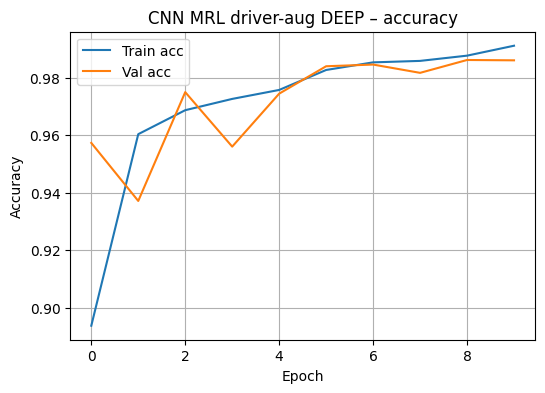

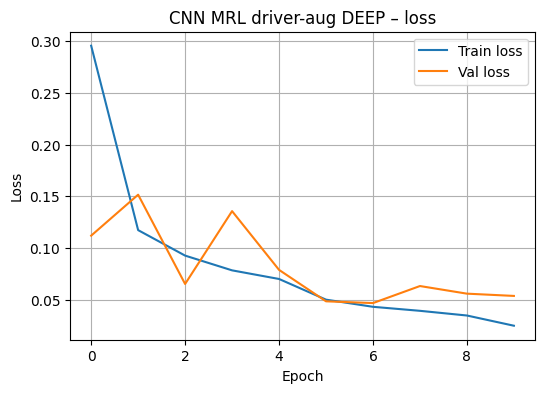

In [27]:
def plot_training_curves_with_title(history, title_prefix="Model"):
    hist = history.history

    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves_with_title(history_deep, "CNN MRL driver-aug DEEP")

In [28]:
# Assuming you still have:
# - file_paths (np.array of paths)
# - true_labels (np.array of 0/1)
# - X (preprocessed image array)
# If not, re-run your earlier block that builds these.

y_true = true_labels
y_scores_deep = model_cnn_deep.predict(X, batch_size=64, verbose=0).ravel()
y_pred_deep = (y_scores_deep > 0.5).astype(int)

mis_idx_deep = np.where(y_pred_deep != y_true)[0]
len(mis_idx_deep)

263

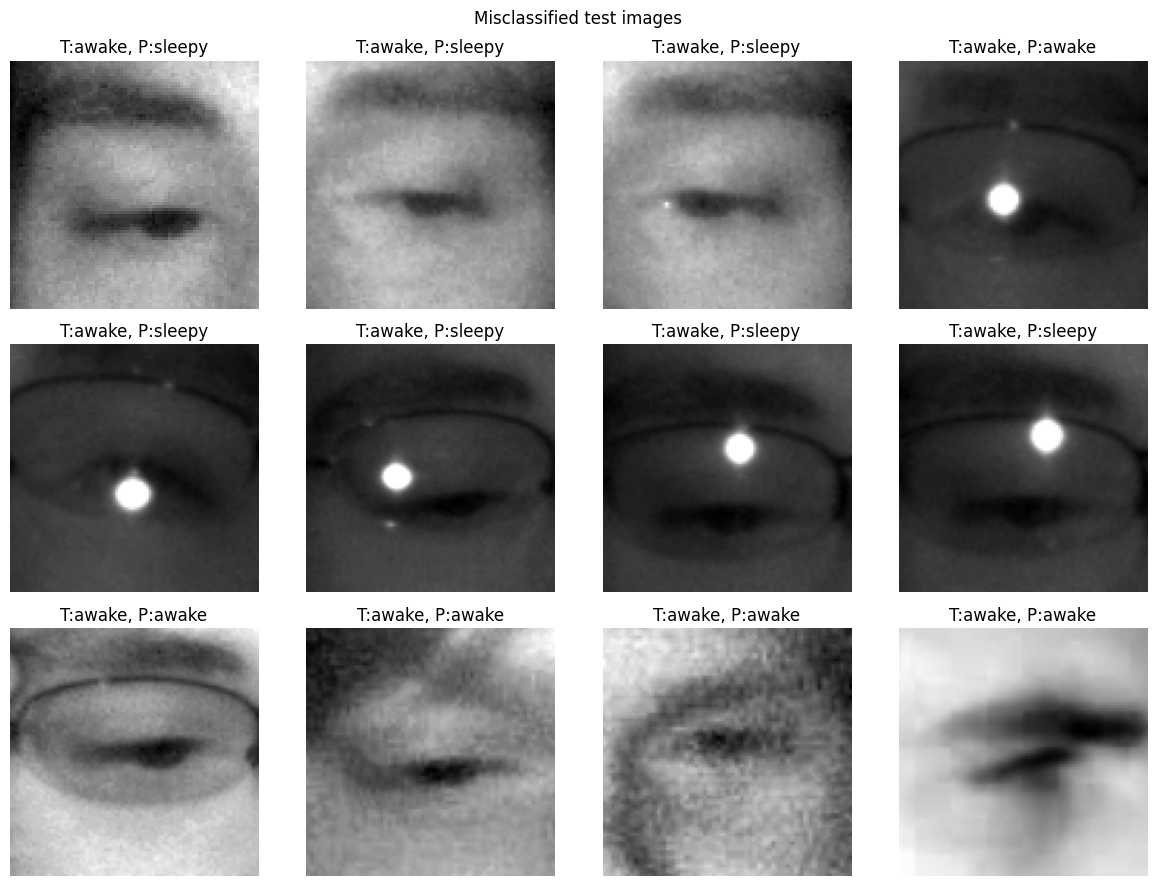

In [29]:
show_mistakes(mis_idx_deep, n=12)

### 3 model comparison

In [30]:
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# --- Load saved models ---
baseline_model = keras.models.load_model("Models/baseline_cnn_mrl.keras")
aug_model      = keras.models.load_model("Models/cnn_mrl_driver_aug.keras")
deep_model     = keras.models.load_model("Models/cnn_mrl_driver_aug_deep.keras")

models = {
    "baseline_cnn": baseline_model,
    "cnn_driver_aug": aug_model,
    "cnn_driver_aug_deep": deep_model,
}

results = []

# helper to collect y_true and scores for a model
def collect_scores(model, dataset):
    all_y = []
    all_s = []
    for x_batch, y_batch in dataset:
        s = model.predict(x_batch, verbose=0).ravel()  # probabilities
        all_s.append(s)
        all_y.append(y_batch.numpy().ravel())
    y_true = np.concatenate(all_y)
    y_scores = np.concatenate(all_s)
    return y_true, y_scores

for name, m in models.items():
    print(f"\n================ {name} ================")
    loss, acc = m.evaluate(test_ds, verbose=0)
    print(f"Test accuracy: {acc:.4f}  |  Test loss: {loss:.4f}")

    y_true, y_scores = collect_scores(m, test_ds)
    y_pred = (y_scores > 0.5).astype(int)

    print("Classification report (threshold = 0.5):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["awake", "sleepy"],
        digits=4
    ))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    results.append({
        "model": name,
        "test_acc": acc,
        "test_loss": loss,
        "tn": cm[0,0],
        "fp": cm[0,1],
        "fn": cm[1,0],
        "tp": cm[1,1],
    })

results_df = pd.DataFrame(results)
print("\n=== Summary across models ===")
display(results_df)


================ baseline_cnn ================
Test accuracy: 0.9859  |  Test loss: 0.0451
Classification report (threshold = 0.5):
              precision    recall  f1-score   support

       awake     0.9889    0.9831    0.9860      8591
      sleepy     0.9828    0.9887    0.9857      8390

    accuracy                         0.9859     16981
   macro avg     0.9858    0.9859    0.9859     16981
weighted avg     0.9859    0.9859    0.9859     16981

Confusion matrix:
 [[8446  145]
 [  95 8295]]

================ cnn_driver_aug ================
Test accuracy: 0.9815  |  Test loss: 0.0517
Classification report (threshold = 0.5):
              precision    recall  f1-score   support

       awake     0.9824    0.9810    0.9817      8591
      sleepy     0.9806    0.9820    0.9813      8390

    accuracy                         0.9815     16981
   macro avg     0.9815    0.9815    0.9815     16981
weighted avg     0.9815    0.9815    0.9815     16981

Confusion matrix:
 [[8428  163]


2025-12-03 05:06:10.960129: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0} %bitcast.503, f32[64,32,3,3]{3,2,1,0} %bitcast.510, f32[64]{0} %bitcast.512), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="cnn_mrl_driver_aug_deep_1/conv2d_7_1/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-03 05:06:10.990549: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pic

Classification report (threshold = 0.5):
              precision    recall  f1-score   support

       awake     0.9811    0.9872    0.9842      8591
      sleepy     0.9868    0.9806    0.9837      8390

    accuracy                         0.9839     16981
   macro avg     0.9840    0.9839    0.9839     16981
weighted avg     0.9839    0.9839    0.9839     16981

Confusion matrix:
 [[8481  110]
 [ 163 8227]]

=== Summary across models ===


,model,test_acc,test_loss,tn,fp,fn,tp
0,baseline_cnn,0.985867,0.045149,8446,145,95,8295
1,cnn_driver_aug,0.981509,0.051750,8428,163,151,8239
2,cnn_driver_aug_deep,0.983923,0.048477,8481,110,163,8227


### Threshold Sweep

In [31]:
# Use the deep driver model for threshold tuning
model_for_threshold = deep_model

y_true, y_scores = collect_scores(model_for_threshold, test_ds)

thresholds = np.linspace(0.1, 0.9, 17)  # 0.10, 0.15, ..., 0.90
rows = []

for t in thresholds:
    y_pred = (y_scores > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # sleepy = positive class (1)
    recall_sleepy    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precision_sleepy = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # false-alarm rate on awake class
    fpr_awake = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    rows.append({
        "threshold": t,
        "recall_sleepy": recall_sleepy,
        "precision_sleepy": precision_sleepy,
        "false_positive_rate_awake": fpr_awake,
    })

thresh_df = pd.DataFrame(rows)
print("Threshold sweep for cnn_driver_aug_deep:")
display(thresh_df)

2025-12-03 05:06:53.865359: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Threshold sweep for cnn_driver_aug_deep:


,threshold,recall_sleepy,precision_sleepy,false_positive_rate_awake
0,0.10,0.994398,0.963061,0.037248
1,0.15,0.993325,0.969182,0.030846
2,0.20,0.992014,0.973109,0.026772
3,0.25,0.990584,0.976386,0.023397
4,0.30,0.988558,0.978874,0.020836
5,0.35,0.987128,0.981163,0.018508
6,0.40,0.984863,0.983456,0.016180
7,0.45,0.982479,0.985180,0.014434
8,0.50,0.980572,0.986806,0.012804
9,0.55,0.978308,0.987607,0.011989


### threshold 0.4. We would rather be safe 

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Choose operating threshold for driver safety
OP_THRESHOLD = 0.40

y_pred_op = (y_scores > OP_THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_op).ravel()

print(f"Operating threshold: {OP_THRESHOLD}")
print("Confusion matrix (awake=0, sleepy=1):")
print(confusion_matrix(y_true, y_pred_op))

print("\nClassification report at operating point:")
print(classification_report(
    y_true,
    y_pred_op,
    target_names=["awake", "sleepy"],
    digits=4
))

print(f"False-positive rate on awake: {fp / (fp + tn):.4f}")
print(f"Recall (sleepy): {tp / (tp + fn):.4f}")

Operating threshold: 0.4
Confusion matrix (awake=0, sleepy=1):
[[8452  139]
 [ 127 8263]]

Classification report at operating point:
              precision    recall  f1-score   support

       awake     0.9852    0.9838    0.9845      8591
      sleepy     0.9835    0.9849    0.9842      8390

    accuracy                         0.9843     16981
   macro avg     0.9843    0.9843    0.9843     16981
weighted avg     0.9843    0.9843    0.9843     16981

False-positive rate on awake: 0.0162
Recall (sleepy): 0.9849
